In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
plt.style.use('dark_background')

In [2]:
import cypari

# Tree Structure

In [3]:
class treeNode(object):
    def __init__(self, matrix=None, address="", 
                       leftChild=None, rightChild=None):
        """ A node of the Farey binary tree.
            Args:
            
            matrix: np 2x2 matrix (dtype=np.int64)
            address: string of 'L' and 'R' giving the address in the tree.
            leftChild, rightChild: children of that node.
        """
        
        self.matrix = matrix
        self.address = address
        self.leftChild = leftChild
        self.rightChild = rightChild
        
    def get_coord(self):
        """ Transforms the matrix in coordinates.
        """
        return sum(self.matrix[0]), sum(self.matrix[1])
    
    def get_trace(self):
        return self.matrix.trace()

In [4]:
def tree_size(node):
    """ Returns the numbe of nodes in the tree of a given root.
    """
    if node is None:
        return 0
    return 1 + tree_size(node.leftChild) + tree_size(node.rightChild)

In [5]:
def get_nodes_with_property(root, prop):
    """ Returns all nodes of the tree having the given property.
        Args:
        
        root: root of the tree (type treeNode)
        prop: predicate treeNode -> bool
    """
    
    if root is None:
        return []
    
    if prop(root):
        l = [root]
    else:
        l = []
    
    return l + get_nodes_with_property(root.leftChild, prop)+ get_nodes_with_property(root.rightChild, prop)

In [6]:
def get_trace_property(trace):
    """ Returns a predicate treeNode -> bool, choosing nodes which have a given trace.
    """
    def trace_property(node):
        return node.get_trace() == trace
    return trace_property

# Tree Construction

In [7]:
def construct_tree(include_node_criterion, 
                   left_coord=(1,0), right_coord=(0,1), 
                   last_address = "", last_move = "", height=0):
    """ Construct the Farey binary tree.
        Args:
        
        include_node_criterion: function that takes a node and the height 
                                and decide whether or not to include this node in the tree (thus stops the construction).
        left_coord: starting at (1,0)
        right_coord: starting at (0,1)
        last_addresss: address of the father
        last_move: last move 'L' or 'R' to get to the current node
        height: current height in the tree
    """
    node = treeNode()
    node.matrix = np.array([left_coord,right_coord], dtype=np.int64)
    node.address = last_address + last_move
    
    
    if not include_node_criterion(node, height):
        return None
    
    node.leftChild = construct_tree(include_node_criterion,
                                    left_coord, node.get_coord(), 
                                    node.address, "L", height+1)
    
    node.rightChild = construct_tree(include_node_criterion,
                                    node.get_coord(), right_coord,
                                    node.address, "R", height+1)
    
    return node

## Stopping Criterion

In [8]:
def get_p_q_criterion(max_p, max_q):
    def p_q_criterion(node, height):
        return node.get_coord()[0] <= max_p and node.get_coord()[1] <= max_q
    return p_q_criterion

In [9]:
def get_max_height_criterion(max_height):
    def max_height_criterion(node, height):
        return height <= max_height
    return max_height_criterion

# Running

In [10]:
root = construct_tree(get_max_height_criterion(16))
tree_size(root)

131071

In [11]:
def get_coord_and_trace(node):
    """ Returns a list of the (coordinate, trace) of nodes in the tree.
    """
    
    if node is None:
        return []
    
    return [(node.get_coord(), node.get_trace())] + get_coord_and_trace(node.leftChild) + get_coord_and_trace(node.rightChild)

In [41]:
coord_and_trace = get_coord_and_trace(root)
coords = np.array( [ct[0] for ct in coord_and_trace] )

In [42]:
sub_coords = np.array([ a for a in coords if a[0] <= 100 and a[1] <= 100])
sub_trace = np.array([ct[1] for ct in coord_and_trace if ct[0][0] <= 100 and ct[0][1] <= 100])

In [43]:
def get_coords_with_trace(coord_and_trace, t):
    return np.array([ ct[0] for ct in coord_and_trace if ct[1] == t ])

## Plotting all matrices, color is trace

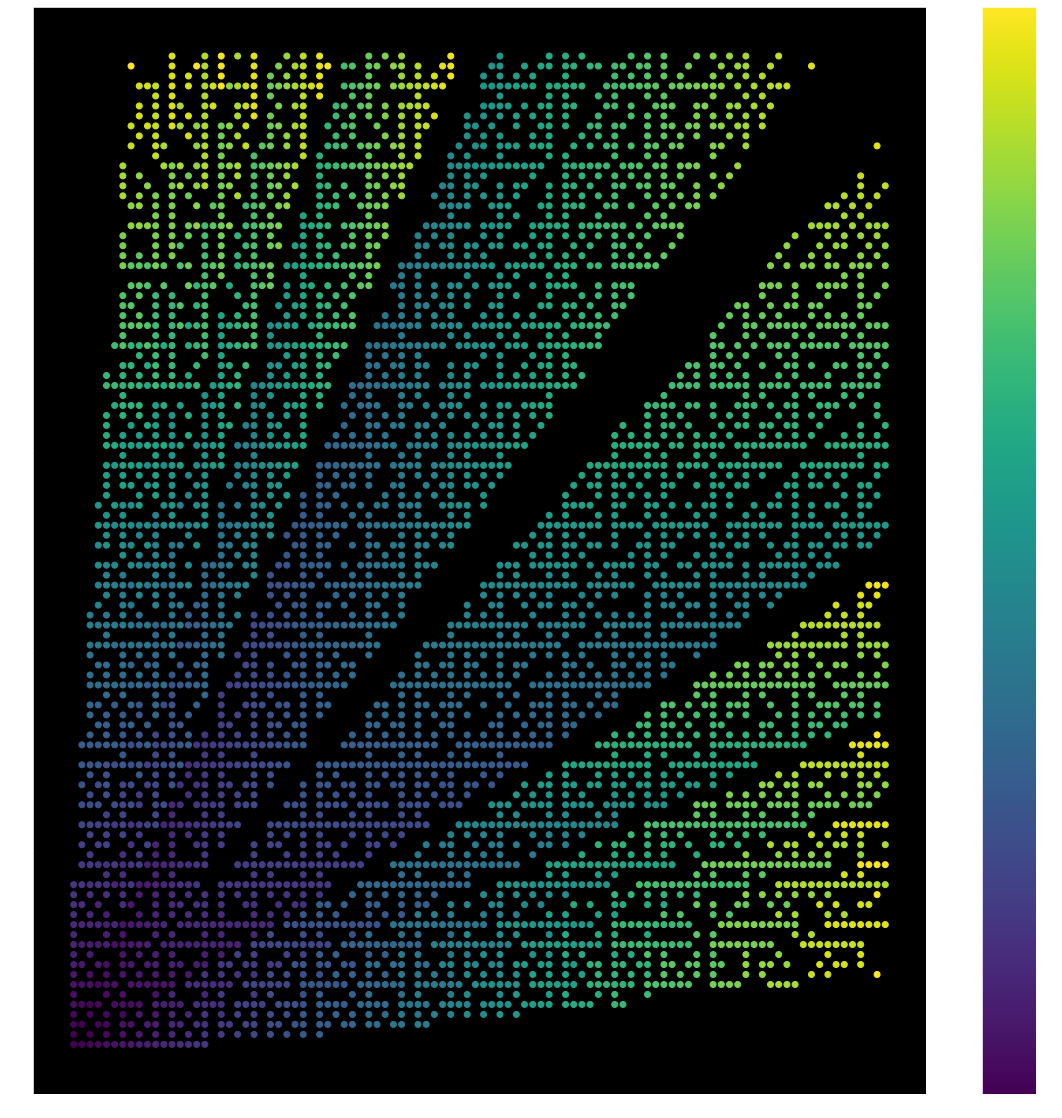

In [44]:
plt.figure(figsize=(20,20))
plt.scatter(sub_coords[:,0], sub_coords[:,1], c= sub_trace)
plt.colorbar()
plt.savefig('images/hihi_color.png')
plt.show()

## Plotting matrices per trace

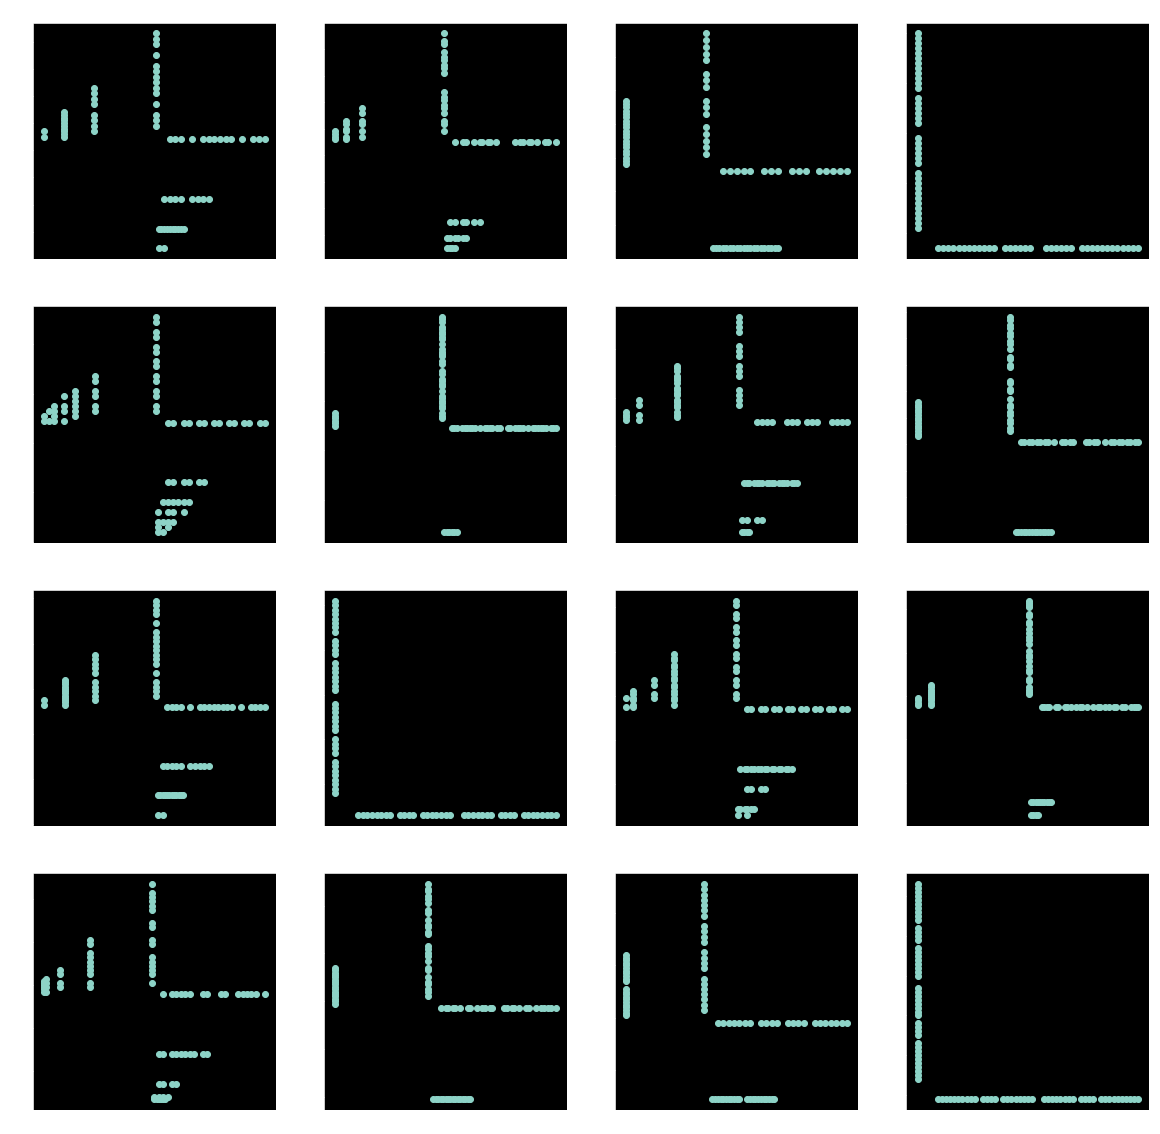

In [45]:
plt.figure(figsize=(20,20))
offset = 44
for i in range(0,16):
    plt.subplot(4,4,i+1)
    coords = get_coords_with_trace(coord_and_trace,i+offset)
    plt.scatter(coords[:,0], coords[:, 1])
    plt.title("Trace = {}".format(i+offset))
plt.savefig("images/ALotOfTrace2.png")
plt.show()

# Between t=3 and t=31

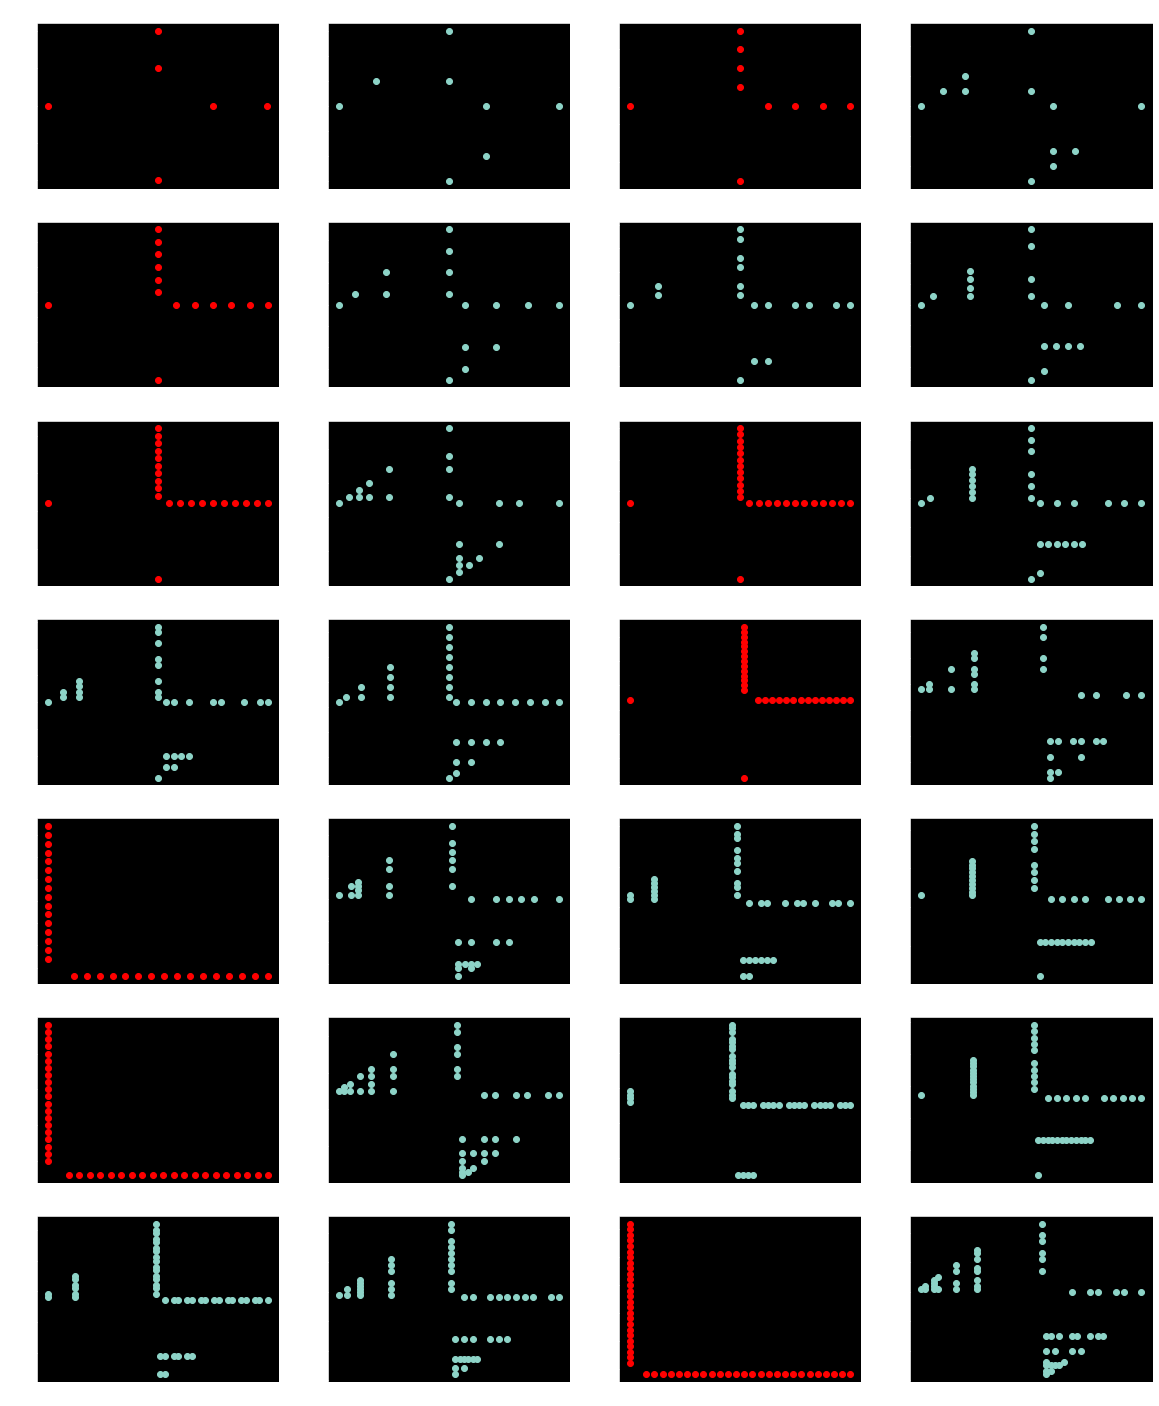

In [46]:
plt.figure(figsize=(20,25))
offset = 3
for i in range(0,28):
    plt.subplot(7,4,i+1)
    coords = get_coords_with_trace(coord_and_trace,i+offset)
    if cypari.pari('isprime({})'.format(i+offset)):
        plt.scatter(coords[:,0], coords[:, 1], c='r')
    else:
        plt.scatter(coords[:,0], coords[:, 1])
    plt.title("Trace = {}".format(i+offset))
plt.savefig("images/trace_1_to_31.png")
plt.show()

## t = 5

In [12]:
def get_circular_shifts(word):
    """ Returns all the circular shifts of 'word'.
    """
    n = len(word)
    return ["".join([word[i - j] for i in range(n)]) for j in range(n)]

In [13]:
def get_circular_rep(word):
    """ Returns the min (lex order) of the circular permutations of 'word'.
    """
    if word == '':
        return ''
    return min(get_circular_shifts(word))

In [15]:
def get_conjugaison_classes(nodes):
    """ Gets a list of nodes and return list of (node, class number, class_rep).
    """
    classes = {}
    for n in nodes:
        rep = get_circular_rep(n.address)
        if not rep in classes:
            classes[rep] = []
        classes[rep].append(n)
    
    sorted_class = sorted(list(classes.items()), key=lambda x: len(x[0]))
    
    to_return = []
    for i,(rep,class_) in enumerate(sorted_class):
        for n in class_:
            to_return.append((n,i,rep))
            
    return to_return, len(classes)

In [16]:
def plot_conj_classes(root, trace, save=None):
    nodes = get_nodes_with_property(root, get_trace_property(trace))
    conj_classes, nb_classes = get_conjugaison_classes(nodes)
    
    coords = np.array([n[0].get_coord() for n in conj_classes ])
    colors = [n[1] for n in conj_classes ]
    
    plt.figure(figsize=(10,10))
    plt.scatter(coords[:,0],coords[:,1], c=colors)
    
    plt.title("Their are {} conjugaison classes, {} matrices, for trace = {}".format(nb_classes, len(coords), trace))
    if not save is None:
        plt.savefig("images/"+save)
    plt.show()

In [17]:
def plot_conj_classes2(root, trace, print_rep=False, save=None):
    nodes = get_nodes_with_property(root, get_trace_property(trace))
    conj_classes, nb_classes = get_conjugaison_classes(nodes)
    
    coords = np.array([n[0].get_coord() for n in conj_classes ])
    if not print_rep:
        colors = [n[1] for n in conj_classes ]
    else:
        colors = [n[2] for n in conj_classes ]
    fig, ax = plt.subplots(figsize=(10,10))
    plt.scatter(coords[:,0],coords[:,1])

    for i, txt in enumerate(colors):
        ax.annotate(txt, (coords[i,0]+0.3,coords[i,1]))
    
    plt.title("Their are {} conjugaison classes, {} matrices, for trace = {}".format(nb_classes, len(coords), trace))
    if not save is None:
        plt.savefig("images/"+save)
    plt.show()

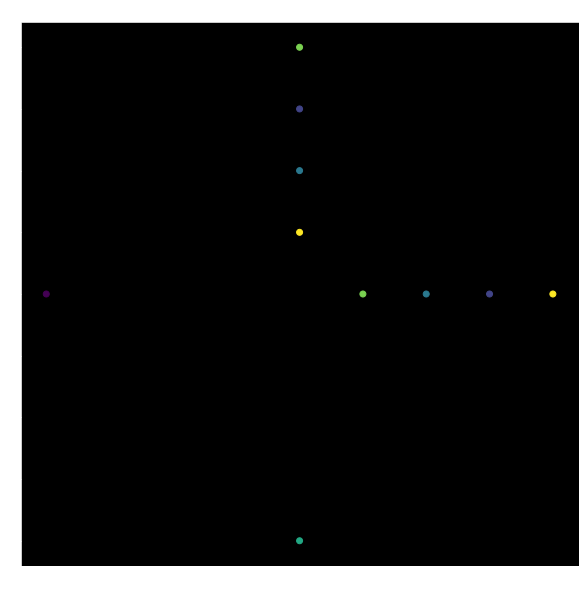

In [18]:
plot_conj_classes(root, 5, save="conjClass5.png")

## Other t

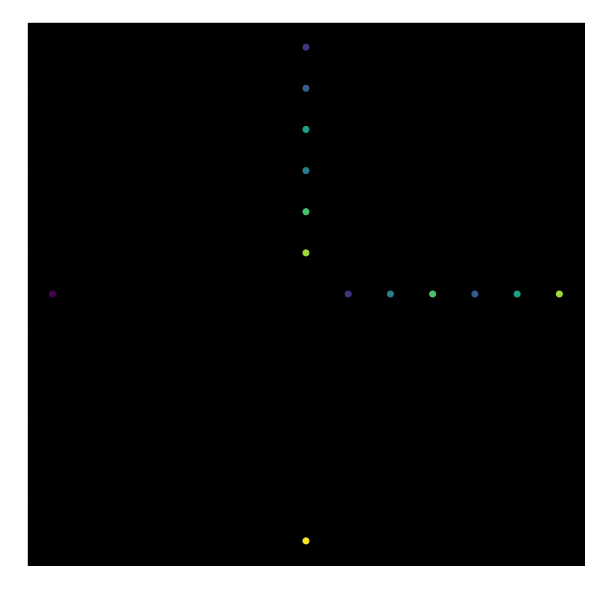

In [108]:
plot_conj_classes(root, 7, save="conjClass7.png")

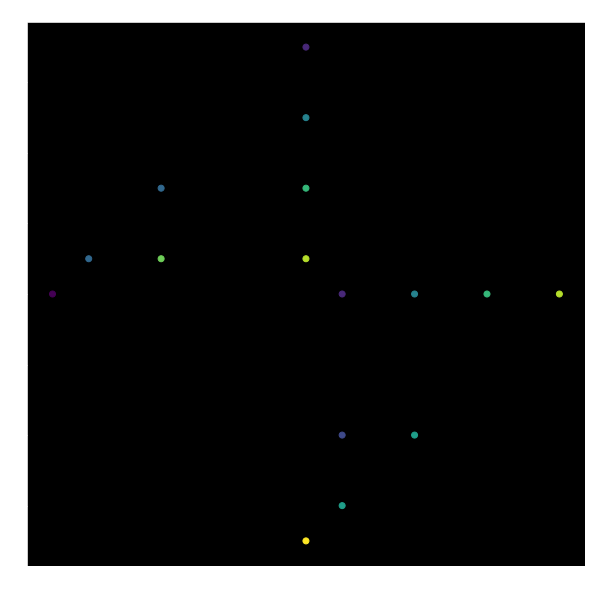

In [107]:
i = 8
plot_conj_classes(root, i, save="conjClass{}.png".format(i))

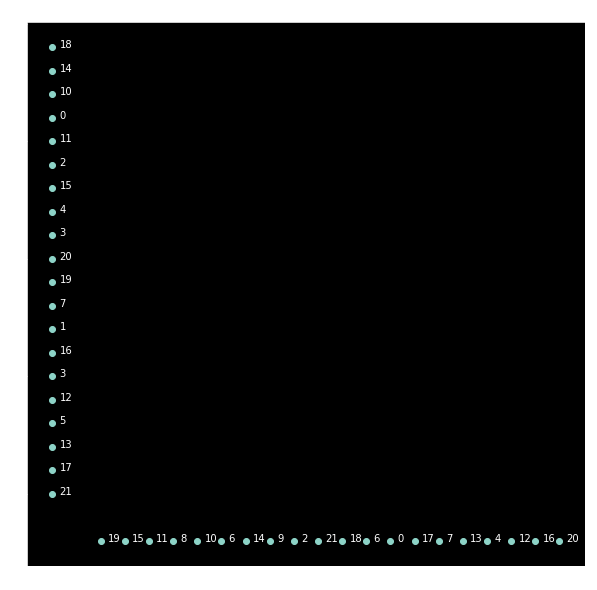

In [122]:
i = 23
plot_conj_classes2(root, i, print_rep=False, save="conjClass_text{}.png".format(i))

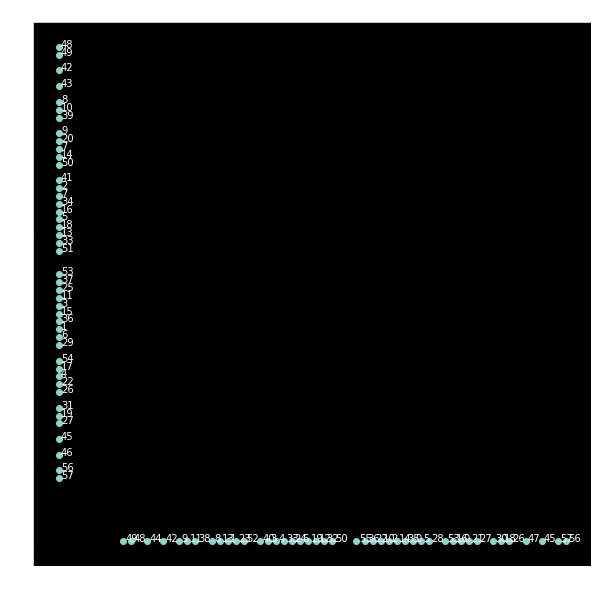

In [130]:
i = 71
plot_conj_classes2(root, i, save="conjClass_text{}.png".format(i))

In [20]:
from ipywidgets import Button

# Growth of nb matrices per trace

In [22]:
nb_matrices = []
nb_conj = []
for t in range(2,100):
    nodes = get_nodes_with_property(root, get_trace_property(t))
    nb_matrices.append(len(nodes))
    nb_conj.append(get_conjugaison_classes(nodes)[1])

In [59]:
nb_matrices = np.array(nb_matrices)
nb_conj = np.array(nb_conj)

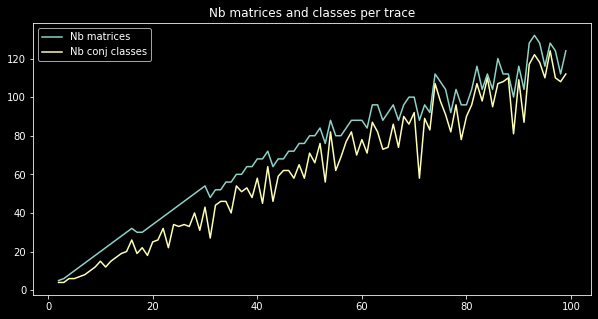

In [159]:
rng = list(range(2,100))
plt.figure(figsize=(10,5))
plt.plot(rng,nb_matrices,label="Nb matrices")
plt.plot(rng,nb_conj,label="Nb conj classes")
plt.legend()
plt.title("Nb matrices and classes per trace")
plt.savefig("images/nb_mat_per_trace.png")
plt.show()

In [48]:
primes100 = np.array(list(map(int, list(cypari.pari('primes(100)')))))

In [57]:
nb_matrices[primes100[primes100 < 100]-2]

array([  5,   6,  10,  14,  22,  26,  30,  32,  40,  52,  48,  60,  68,
        64,  72,  76,  88,  84,  88,  88,  92,  96, 104, 100, 124])

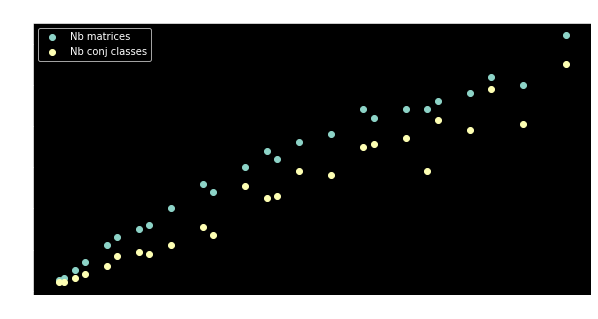

In [62]:
rng = primes100[primes100 < 100]
plt.figure(figsize=(10,5))
plt.plot(rng,nb_matrices[primes100[primes100 < 100]-2],'o',label="Nb matrices")
plt.plot(rng,nb_conj[primes100[primes100 < 100]-2],'o', label="Nb conj classes")
plt.legend()
plt.title("Nb matrices and classes per prime trace < 100")
plt.savefig("images/nb_mat_per_prime_trace.png")
plt.show()

## t = 11

In [63]:
nodes = get_nodes_with_property(root, get_trace_property(11))

In [68]:
for n in nodes:
    print(n.address)
conj_class,n_classes = get_conjugaison_classes(nodes)
for n in conj_class:
    print((n[0].address,n[1]))

LLLLLLLLLL
LLLLLLLLLLR
LLLLLLLLLRL
LLLLRLR
LLLLRRL
LLRLLR
LLRLRL
LRLLLR
LRLLRL
LRRRRLR
LRRRRRL
RLLLLLR
RLLLLRL
RLRRLR
RLRRRL
RRLRLR
RRLRRL
RRRRLLR
RRRRLRL
RRRRRRRRRLR
RRRRRRRRRR
RRRRRRRRRRL
('LLRLLR', 0)
('LRLLRL', 0)
('LLRLRL', 1)
('LRLLLR', 1)
('RLRRLR', 2)
('RRLRRL', 2)
('RLRRRL', 3)
('RRLRLR', 3)
('LLLLRLR', 4)
('RLLLLRL', 4)
('LLLLRRL', 5)
('RLLLLLR', 5)
('LRRRRLR', 6)
('RRRRLRL', 6)
('LRRRRRL', 7)
('RRRRLLR', 7)
('LLLLLLLLLL', 8)
('RRRRRRRRRR', 9)
('LLLLLLLLLLR', 10)
('LLLLLLLLLRL', 10)
('RRRRRRRRRLR', 11)
('RRRRRRRRRRL', 11)


## t = 23

In [70]:
nodes = get_nodes_with_property(root, get_trace_property(23))
for n in nodes:
    print(n.address)
conj_class,n_classes = get_conjugaison_classes(nodes)
for n in conj_class:
    print((n[0].address,n[1]))

LLLLLLLLLLRLR
LLLLLLLLLLRRL
LLLLLLRLLR
LLLLLLRLRL
LLLLRLLLR
LLLLRLLRL
LLLRLRLR
LLLRLRRL
LLRLLLLLR
LLRLLLLRL
LLRRRLLR
LLRRRLRL
LRLLLLLLLR
LRLLLLLLRL
LRLRRRLR
LRLRRRRL
LRRRLLLR
LRRRLLRL
LRRRRRRRRRRLR
LRRRRRRRRRRRL
RLLLLLLLLLLLR
RLLLLLLLLLLRL
RLLLRRLR
RLLLRRRL
RLRLLLLR
RLRLLLRL
RLRRRRRRLR
RLRRRRRRRL
RRLLLRLR
RRLLLRRL
RRLRRRRLR
RRLRRRRRL
RRRLRLLR
RRRLRLRL
RRRRLRRLR
RRRRLRRRL
RRRRRRLRLR
RRRRRRLRRL
RRRRRRRRRRLLR
RRRRRRRRRRLRL
('LLLRLRLR', 0)
('RLRLLLRL', 0)
('LLLRLRRL', 1)
('LLRRRLLR', 2)
('LRRRLLRL', 2)
('LLRRRLRL', 3)
('RLLLRRRL', 3)
('LRLRRRLR', 4)
('RRRLRLRL', 4)
('LRLRRRRL', 5)
('LRRRLLLR', 6)
('RRLLLRLR', 6)
('RLLLRRLR', 7)
('RRLLLRRL', 7)
('RLRLLLLR', 8)
('RRRLRLLR', 9)
('LLLLRLLLR', 10)
('LLRLLLLRL', 10)
('LLLLRLLRL', 11)
('LLRLLLLLR', 11)
('RRLRRRRLR', 12)
('RRRRLRRRL', 12)
('RRLRRRRRL', 13)
('RRRRLRRLR', 13)
('LLLLLLRLLR', 14)
('LRLLLLLLRL', 14)
('LLLLLLRLRL', 15)
('LRLLLLLLLR', 15)
('RLRRRRRRLR', 16)
('RRRRRRLRRL', 16)
('RLRRRRRRRL', 17)
('RRRRRRLRLR', 17)
('LLLLLLLLLLRLR', 18)
('

In [71]:
nodes = get_nodes_with_property(root, get_trace_property(21))
for n in nodes:
    print(n.address)
conj_class,n_classes = get_conjugaison_classes(nodes)
for n in conj_class:
    print((n[0].address,n[1]))

LLLLLLLLLRLR
LLLLLLLLLRRL
LLLLLLRRR
LLLLLRLLL
LLLLRRRLR
LLLLRRRRL
LLLRRRRLR
LLLRRRRRL
LLRLRRR
LLRRLLL
LLRRRRRRR
LRLLLLLLL
LRLRLLR
LRLRLRL
LRRLRRR
LRRRLLL
LRRRRRRRRRLR
LRRRRRRRRRRL
RLLLLLLLLLLR
RLLLLLLLLLRL
RLLLRRR
RLLRLLL
RLRLRLR
RLRLRRL
RLRRRRRRR
RRLLLLLLL
RRLLRRR
RRLRLLL
RRRLLLLLR
RRRLLLLRL
RRRRLLLLR
RRRRLLLRL
RRRRRLRRR
RRRRRRLLL
RRRRRRRRRLLR
RRRRRRRRRLRL
('LLRLRRR', 0)
('LLRRLLL', 1)
('LRLRLLR', 2)
('LRLRLRL', 2)
('LRRLRRR', 3)
('LRRRLLL', 4)
('RLLLRRR', 5)
('RLLRLLL', 6)
('RLRLRLR', 7)
('RLRLRRL', 7)
('RRLLRRR', 8)
('RRLRLLL', 9)
('LLLLLLRRR', 10)
('LLLLLRLLL', 11)
('LRLLLLLLL', 11)
('LLLLRRRLR', 12)
('LLLLRRRRL', 13)
('RRRLLLLLR', 13)
('LLLRRRRLR', 14)
('LLLRRRRRL', 15)
('RRRRLLLLR', 15)
('LLRRRRRRR', 16)
('RLRRRRRRR', 17)
('RRRRRLRRR', 17)
('RRLLLLLLL', 18)
('RRRLLLLRL', 19)
('RRRRLLLRL', 20)
('RRRRRRLLL', 21)
('LLLLLLLLLRLR', 22)
('RLLLLLLLLLRL', 22)
('LLLLLLLLLRRL', 23)
('RLLLLLLLLLLR', 23)
('LRRRRRRRRRLR', 24)
('RRRRRRRRRLRL', 24)
('LRRRRRRRRRRL', 25)
('RRRRRRRRRLLR', 25)


Mais alors, PSL_2(Z) c'est Q ?